<a href="https://colab.research.google.com/github/Yozhishe/DLS/blob/main/hw_6_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>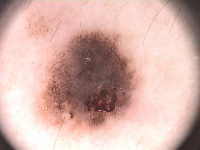</td><td>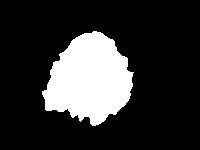</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=342b1d46-a39d-402d-bcd8-aab8df4852b1
To: /content/PH2Dataset.rar
100% 162M/162M [00:00<00:00, 282MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

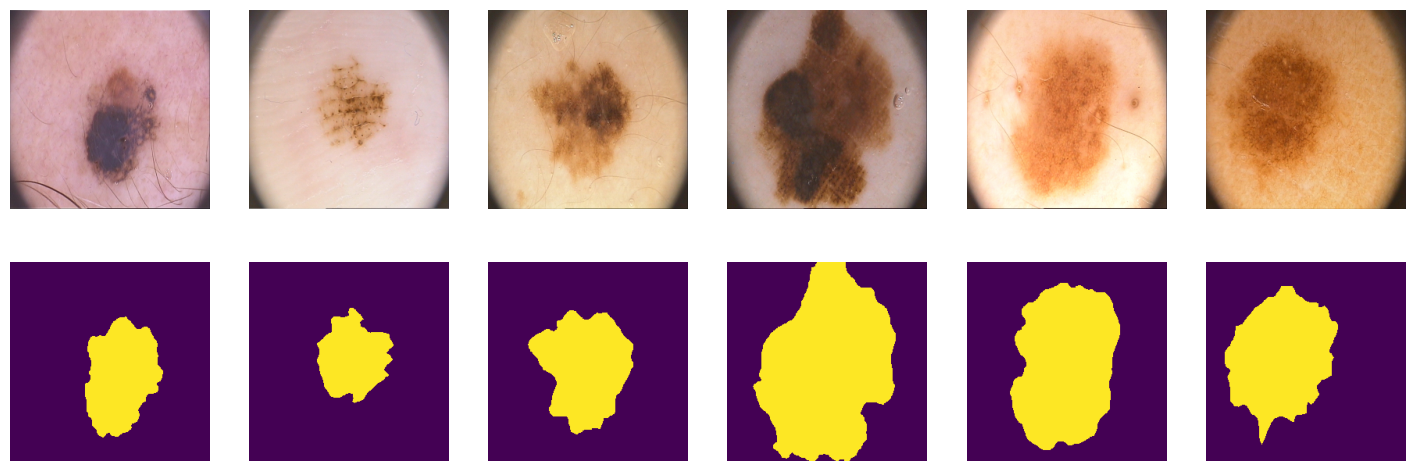

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.7 MB/s eta 0:00:00


In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**


y * -log(sigmoid(y^)) + (1 - y) * -log(1 - sigmoid(y^))

= y * -log(1 / (1 + exp(-y^))) + (1 - y) * -log(exp(-y^) / (1 + exp(-y^)))

= y * log(1 + exp(-y^)) + (1 - y) * (-log(exp(-y^)) + log(1 + exp(-y^)))

= y * log(1 + exp(-y^)) + (1 - y) * (y^ + log(1 + exp(-y^)))

= (1 - y) * y^ + log(1 + exp(-y^))

= y^ - y^ * y + log(1 + exp(-y^)

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_true(y_pred, y_real):
  bce_t = -(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))
  return bce_t.sum()
def bce_loss(y_pred, y_real):
  bce_l = y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))
  return bce_l.sum()

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 5.024262428283691
BCE loss честно посчитанный                = 5.024262428283691
BCE loss from torch bce_torch              = 5.024262428283691
BCE loss from torch with logits bce_torch  = 5.024262428283691


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 17.520475387573242
BCE loss честно посчитанный               = 17.520475387573242
BCE loss from torch bce_torch             = 17.520475387573242
BCE loss from torch with logits bce_torch = 17.520475387573242


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.68MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 7.02MB/s]
Download completed


In [21]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

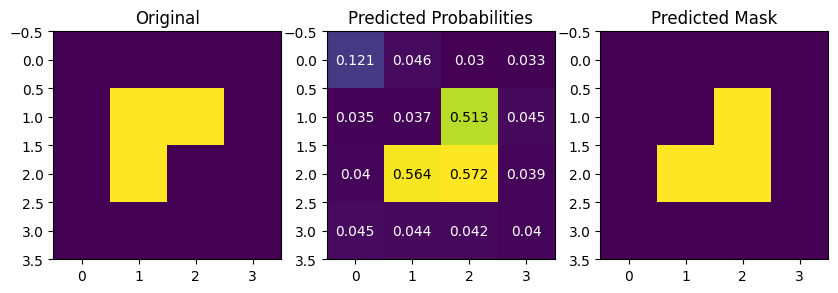

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

***Все сработало без ошибок***

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

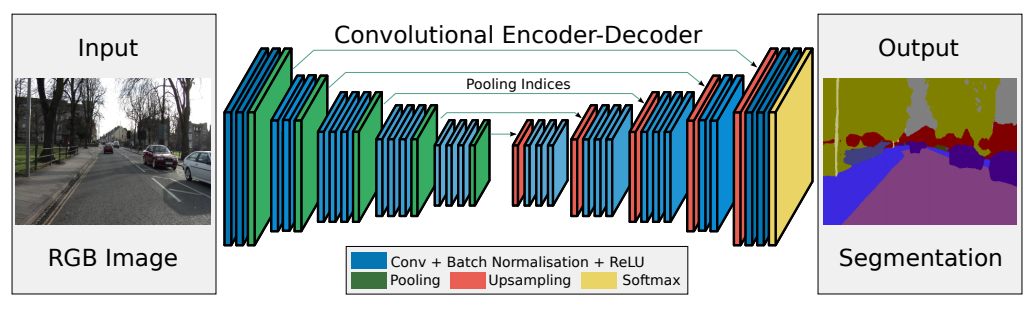

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.2MB/s]


In [26]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [27]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU())

        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU())

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        size_before_pool = x.size()
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices, size_before_pool

По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [28]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.unpooling = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()

        self.layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU())

        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU())

    def forward(self, x, indices, output_size):
        x = self.unpooling(x, indices, output_size=output_size)
        for layer in self.layers:
            x = layer(x)
        return x

Соединим блоки энкодера и декодера в модель SegNet:

In [29]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=2)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=2)
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=2)

        self.bottleneck_conv = nn.Conv2d(num_features * 8, num_features * 8, kernel_size=1)

        self.decoder0 = DecoderBlock(num_features * 8, num_features * 8, depth = 2)
        self.decoder1 = DecoderBlock(num_features * 8, num_features * 4, depth = 2)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth = 2)
        self.decoder3 = DecoderBlock(num_features * 2, num_features, depth = 2)
        self.decoder4 = DecoderBlock(num_features, out_channels, depth = 2)

    def forward(self, x):
        x, indices0, size0 = self.encoder0(x)
        x, indices1, size1 = self.encoder1(x)
        x, indices2, size2 = self.encoder2(x)
        x, indices3, size3 = self.encoder3(x)
        x, indices4, size4 = self.encoder4(x)

        x = self.bottleneck_conv(x)

        x = self.decoder0(x, indices4, size4)
        x = self.decoder1(x, indices3, size3)
        x = self.decoder2(x, indices2, size2)
        x = self.decoder3(x, indices1, size1)
        output = self.decoder4(x, indices0, size0)
        return output

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [30]:
from tqdm.notebook import tqdm
import torch
from torchmetrics import JaccardIndex

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [31]:
def train_one_epoch(model, optimizer, criterion, train_dataloader, device):
  model.train()

  avg_loss = 0
  for X_batch, y_batch in tqdm(train_dataloader):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device).float()

    y_pred = model(X_batch)
    if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
        raise ValueError("Model output contains NaN or Inf values before loss calculation in train_one_epoch!")
    loss = criterion(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    avg_loss += loss.item()

  avg_loss = avg_loss/len(train_dataloader)
  return model, avg_loss
def val(model, criterion, valid_dataloader, device, plot=False):
  iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
  model.eval()

  avg_loss = 0
  avg_iou = 0
  with torch.no_grad():
    for X_batch, y_batch in tqdm(valid_dataloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device).float()

      y_pred = model(X_batch)
      if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
          raise ValueError("Model output contains NaN or Inf values before loss calculation in val!")
      iou = iou_score(y_pred, y_batch)
      loss = criterion(y_pred, y_batch)
      avg_loss += loss.item()
      avg_iou += iou
  avg_loss = avg_loss/len(valid_dataloader)
  avg_iou = avg_iou/len(valid_dataloader)

  if plot:
        clear_output(wait=True)
        our_labels = {
            0: 'Unlabeled',
            1: 'Rodinka'
        }

        fig, axes = plt.subplots(1, 6, figsize=(6*4, 6*4))

        orig_img = X_batch[0].permute(1,2,0).cpu().detach().numpy();
        orig_mask = y_batch[0].squeeze(0).cpu().detach().numpy() # Squeeze the channel dimension

        axes[0].imshow(orig_img);
        axes[0].set_title("Original Image")

        diagram = axes[1].imshow(y_batch[0].squeeze(0).cpu().detach().numpy(), interpolation='none') # Squeeze the channel dimension here too
        values = np.unique(y_batch[0].squeeze(0).cpu().detach().numpy()) # Squeeze here as well
        colors = [ diagram.cmap(diagram.norm(value)) for value in values]
        patches = [mpatches.Patch(color=colors[i], label=f"{i} - {our_labels[i]}" ) for i in range(len(values)) ]
        axes[1].legend(handles=patches, bbox_to_anchor=(1.00, 1), loc=1, borderaxespad=0. )
        axes[1].set_title("Original Mask")

        if y_pred.shape[1] > 1:
            for i in range(min(y_pred.shape[1], 4)):
                axes[2+i].imshow(y_pred[0, i].cpu().detach().numpy() > 0.5)
                axes[2+i].set_title(f"Predicted Mask Channel {i}")
        else:
            axes[2].imshow(y_pred[0, 0].cpu().detach().numpy() > 0.5)
            axes[2].set_title("Predicted Mask")


        plt.show()
  return model, avg_loss, avg_iou

In [32]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = False):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_one_epoch(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = val(model, criterion, valid_dataloader, device, plot=True)
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if plot_loss:
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            ax1.plot(list(range(len(total_train_loss))), total_train_loss, label = 'train loss')
            ax1.plot(list(range(len(total_val_loss))), total_val_loss, label = 'val loss')
            ax1.set_title("Loss")
            ax1.legend()

            if len(total_val_iou) > 0 and isinstance(total_val_iou[0], np.ndarray) and total_val_iou[0].ndim > 0:
                for i in range(total_val_iou[0].shape[0]):
                    ax2.plot(list(range(len(total_val_iou))), [iou[i] for iou in total_val_iou], label = f'val iou class {i}')
            else:
                ax2.plot(list(range(len(total_val_iou))), total_val_iou, label = 'val iou (overall)')
            ax2.set_title("IoU")
            ax2.legend()
            plt.show()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [35]:
import os

epochs = 20
ckpt_path = '/content/checkpoints'

if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='sum')


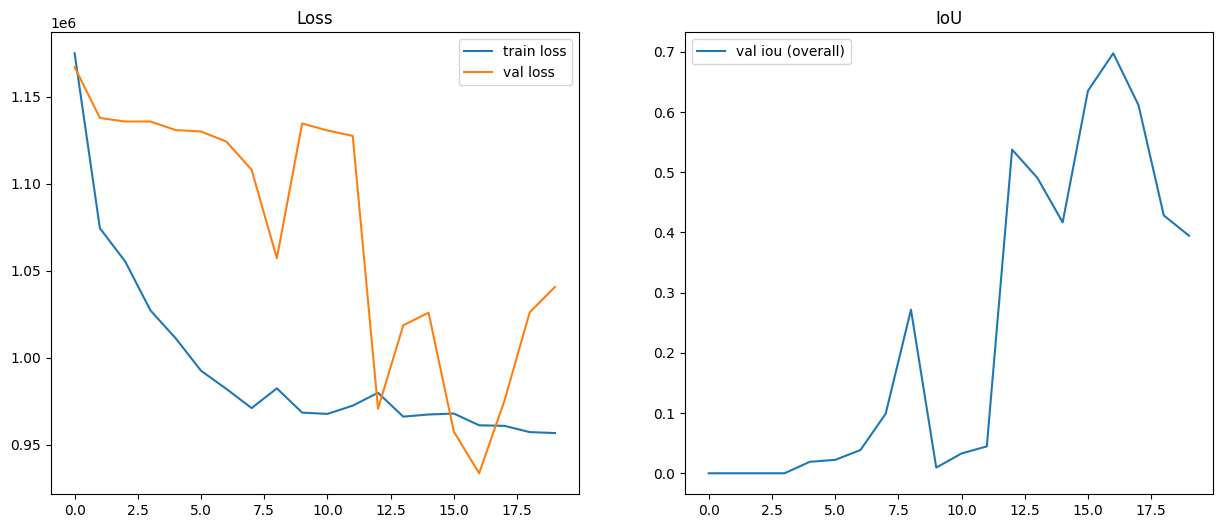

Best checkpoint name: epoch_16_best_val_loss.pt


In [36]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

min_val_loss = min(statistics['val_loss'])
best_epoch_idx = statistics['val_loss'].index(min_val_loss)
ckpt_name = f'epoch_{best_epoch_idx}_best_val_loss.pt'
print(f"Best checkpoint name: {ckpt_name}")

In [153]:
model

SegNet(
  (encoder0): EncoderBlock(
    (layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (maxpooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder1): EncoderBlock(
    (layers): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (maxpooling): MaxPool2d

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [37]:
def test(model, test_dataloader, device, ckpt_path, ckpt_name):

    model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}'))
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch.to(device))
          avg_iou += iou_score(Y_pred, Y_batch)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou

In [38]:
test(model, test_dataloader, device, ckpt_path, ckpt_name)

tensor(0.7129, device='cuda:0')

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [68]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8
    dice = (2*tp + eps) / (2 * tp + fp + fn + eps)
    score = dice

    return score

Проверим на корректность функцию dice_score:

In [86]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.3158, device='cuda:0')

In [51]:
# если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

# from torchmetrics.classification import Dice

# dice = Dice(average='micro').to(device)


In [84]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')

In [87]:
assert dice((dummpy_sample['logits'].sigmoid()>0.5).to(int), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [116]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8
    dice = (2*tp + eps) / (2 * tp + fp + fn + eps)
    loss = 1 - dice

    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

In [117]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary', from_logits=True)
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(torch.float))

tensor(0.5756, device='cuda:0')

In [118]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [119]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [127]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    bce = -(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))
    pt = torch.sigmoid(y_pred) * y_real + (1 - torch.sigmoid(y_pred)) * (1-y_real)
    loss = ((1 - pt)**gamma * bce).sum()

    return loss

Проверка корректности функции:

In [121]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [125]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0')

In [129]:
assert torch.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0))

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Lce(y, p) = −
1
N
X
N
n=1
X
C
c=1
yn,c log(pn,c),

из https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fabs%2F1910.08711

In [136]:
def Lce_loss (y_real, y_pred):
    Lce = -(y_real * torch.log(torch.sigmoid(y_pred))).sum()
    return Lce

In [137]:
Lce_loss(dummpy_sample['labels'], dummpy_sample['logits'])

tensor(4.5469, device='cuda:0')

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?

**Быстрее сошлась на на focal, но при этом взорвались веса**
*   При каком лоссе модель выдает наилучшую метрику?

**Наилучшая iou оказалась при dice лоссе**




In [147]:
class FocalLossWrapper(nn.Module):
    def __init__(self, alpha=-1, gamma=2, reduction='sum'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        return sigmoid_focal_loss(inputs, targets, alpha=self.alpha, gamma=self.gamma, reduction=self.reduction)

criterion_dice = DiceLoss(mode='binary', from_logits=True, smooth=1.0)
criterion_focal = FocalLossWrapper(alpha=-1, gamma=2, reduction='sum')

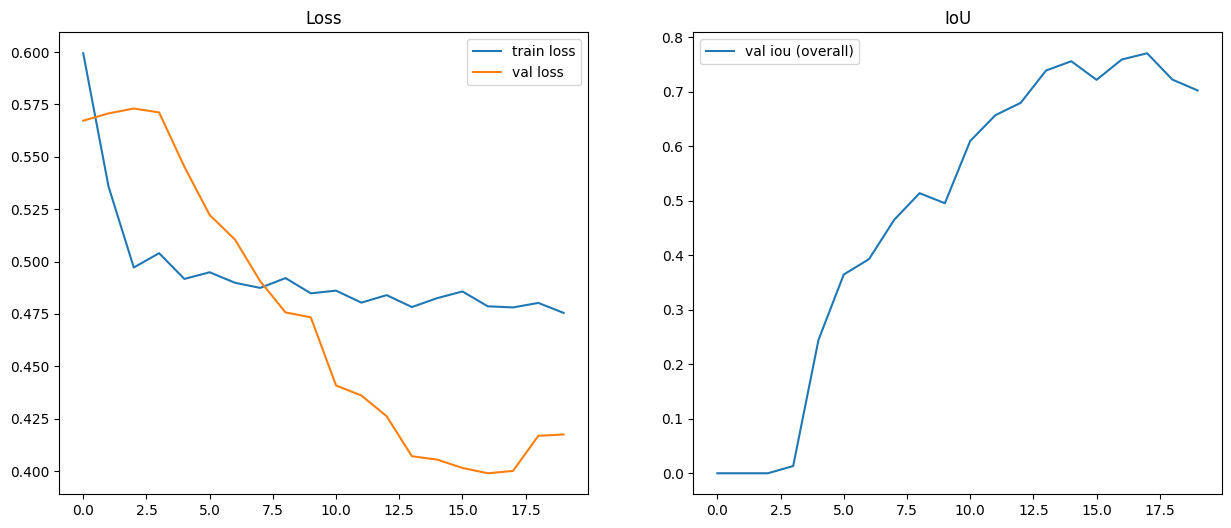

Best checkpoint name for Dice Loss: epoch_16_best_val_loss_dice.pt


In [150]:
print("Training with Dice Loss...")
model_dice = SegNet().to(device)
optimizer_dice = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
model_dice, statistics_dice = train(model_dice, optimizer_dice, criterion_dice, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

min_val_loss_dice = min(statistics_dice['val_loss'])
best_epoch_idx_dice = statistics_dice['val_loss'].index(min_val_loss_dice)
ckpt_name_dice = f'epoch_{best_epoch_idx_dice}_best_val_loss_dice.pt'
print(f"Best checkpoint name for Dice Loss: {ckpt_name_dice}")

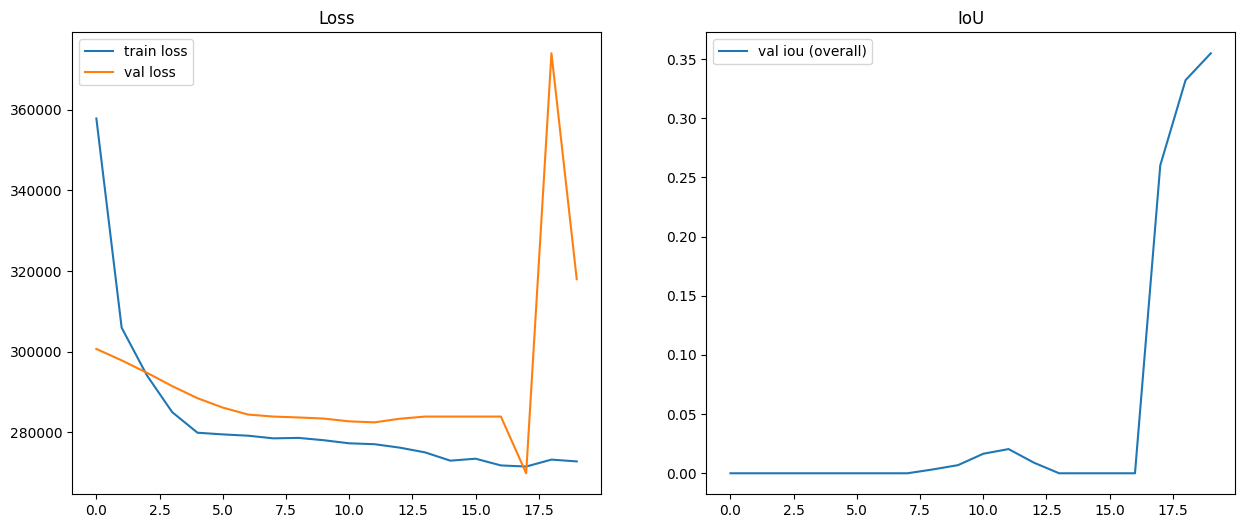

Best checkpoint name for Focal Loss: epoch_17_best_val_loss_focal.pt


In [151]:
print("\nTraining with Focal Loss...")
model_focal = SegNet().to(device)
optimizer_focal = torch.optim.Adam(model_focal.parameters(), lr=1e-3)
model_focal, statistics_focal = train(model_focal, optimizer_focal, criterion_focal, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss = True)

min_val_loss_focal = min(statistics_focal['val_loss'])
best_epoch_idx_focal = statistics_focal['val_loss'].index(min_val_loss_focal)
ckpt_name_focal = f'epoch_{best_epoch_idx_focal}_best_val_loss_focal.pt'
print(f"Best checkpoint name for Focal Loss: {ckpt_name_focal}")

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

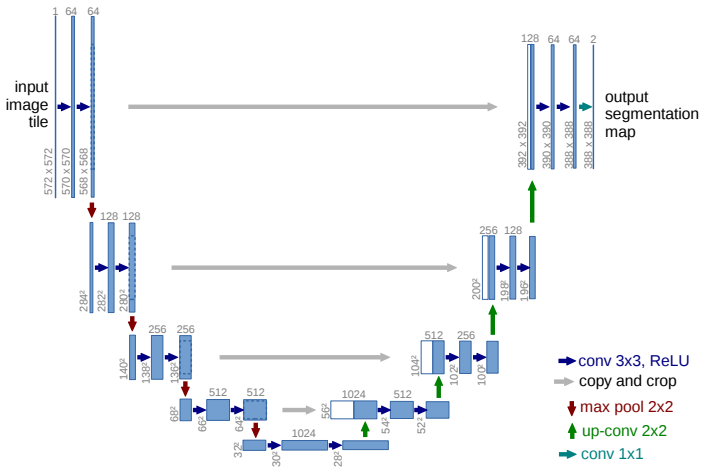

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [152]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [156]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, depth, kernel_size = 3, padding = 1, do_maxpool = True):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(nn.Conv2d(in_channel = in_channel, out_channel = out_channel, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.ReLU())
        self.do_maxpool = do_maxpool
        if self.do_maxpool:
            self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        size_before_pool = x.size()
        for layer in self.layers[:-1]:
          x = layer(x)
        indicies = None
        if self.do_maxpool:
            x, indicies = self.maxpooling(x)

        return x, indicies, size_before_pool

In [ ]:
unet_model = UNet().to(device)

**Я к сожалению не успеваю уже по дедлайну закончить работу, но я честно сам хочу дописать unet потом, поэтому ставьте как хотите эти баллы.**

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

